In [1]:
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
import shutil
import torch
import torch.nn as nn
from collections import OrderedDict
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torch.utils import data
from zplib.image import colorize
from zplib.curve import spline_geometry
from zplib.image import pyramid
import freeimage
import numpy
import torch

from elegant import process_images
from elegant import worm_spline
from elegant import datamodel
from elegant.torch import dataset

import keypoint_annotation_model
import keypoint_training

from keypoint_annotation.model_metrics import model_metrics_new_api
from elegant.torch import dataset
from keypoint_annotation.production import worm_datasets
from keypoint_annotation.production import production_utils
from keypoint_annotation.model_metrics import model_metrics_utils
from keypoint_annotation.dataloaders import training_dataloaders

In [2]:
train = datamodel.Timepoints.from_file('/Volumes/lugia_array/Laird_Nicolette/deep_learning/keypoint_detection/new_api/production_dataloader_test/training_paths/train_path_os.txt')
val = datamodel.Timepoints.from_file('/Volumes/lugia_array/Laird_Nicolette/deep_learning/keypoint_detection/new_api/production_dataloader_test/training_paths/val_path_os.txt')
test = datamodel.Timepoints.from_file('/Volumes/lugia_array/Laird_Nicolette/deep_learning/keypoint_detection/new_api/production_dataloader_test/training_paths/test_path_os.txt')
print(len(train), len(val), len(test))

4515 1322 690


In [3]:
#model parameters
sets = ['train', 'val']
scale = [0,1,2,3]      # the number of output layer for U-net
batch_size = 5
image_size = (960, 96)
total_epoch_num = 150  # total number of epoch in training
base_lr = 0.0005      # base learning rate/
downscale = 1

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): device='cuda:0'

In [4]:
kp_map_generator = training_dataloaders.GaussianKpMap1D(covariate=100, max_val=1)
data_generator = training_dataloaders.WormKeypointDataset(kp_map_generator,downscale=downscale, scale=scale, image_size=image_size)

datasets = {'train': dataset.WormDataset(train, data_generator),
           'val': dataset.WormDataset(val, data_generator),
           'test': dataset.WormDataset(test, data_generator)}

dataloaders = {set_name: DataLoader(datasets[set_name], 
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', num_workers = 4)
               for set_name in sets}
#dataloaders = keypoint_dataloader_maps.generate_dataloader_dict(positions, annotations, downscale=1, transform=transform, batch_size=5)
dataset_sizes = {set_name: len(datasets[set_name]) for set_name in sets}
print(dataset_sizes)

{'train': 4515, 'val': 1322}


torch.Size([5, 3, 960, 96])
torch.Size([5, 1, 960, 96])
4


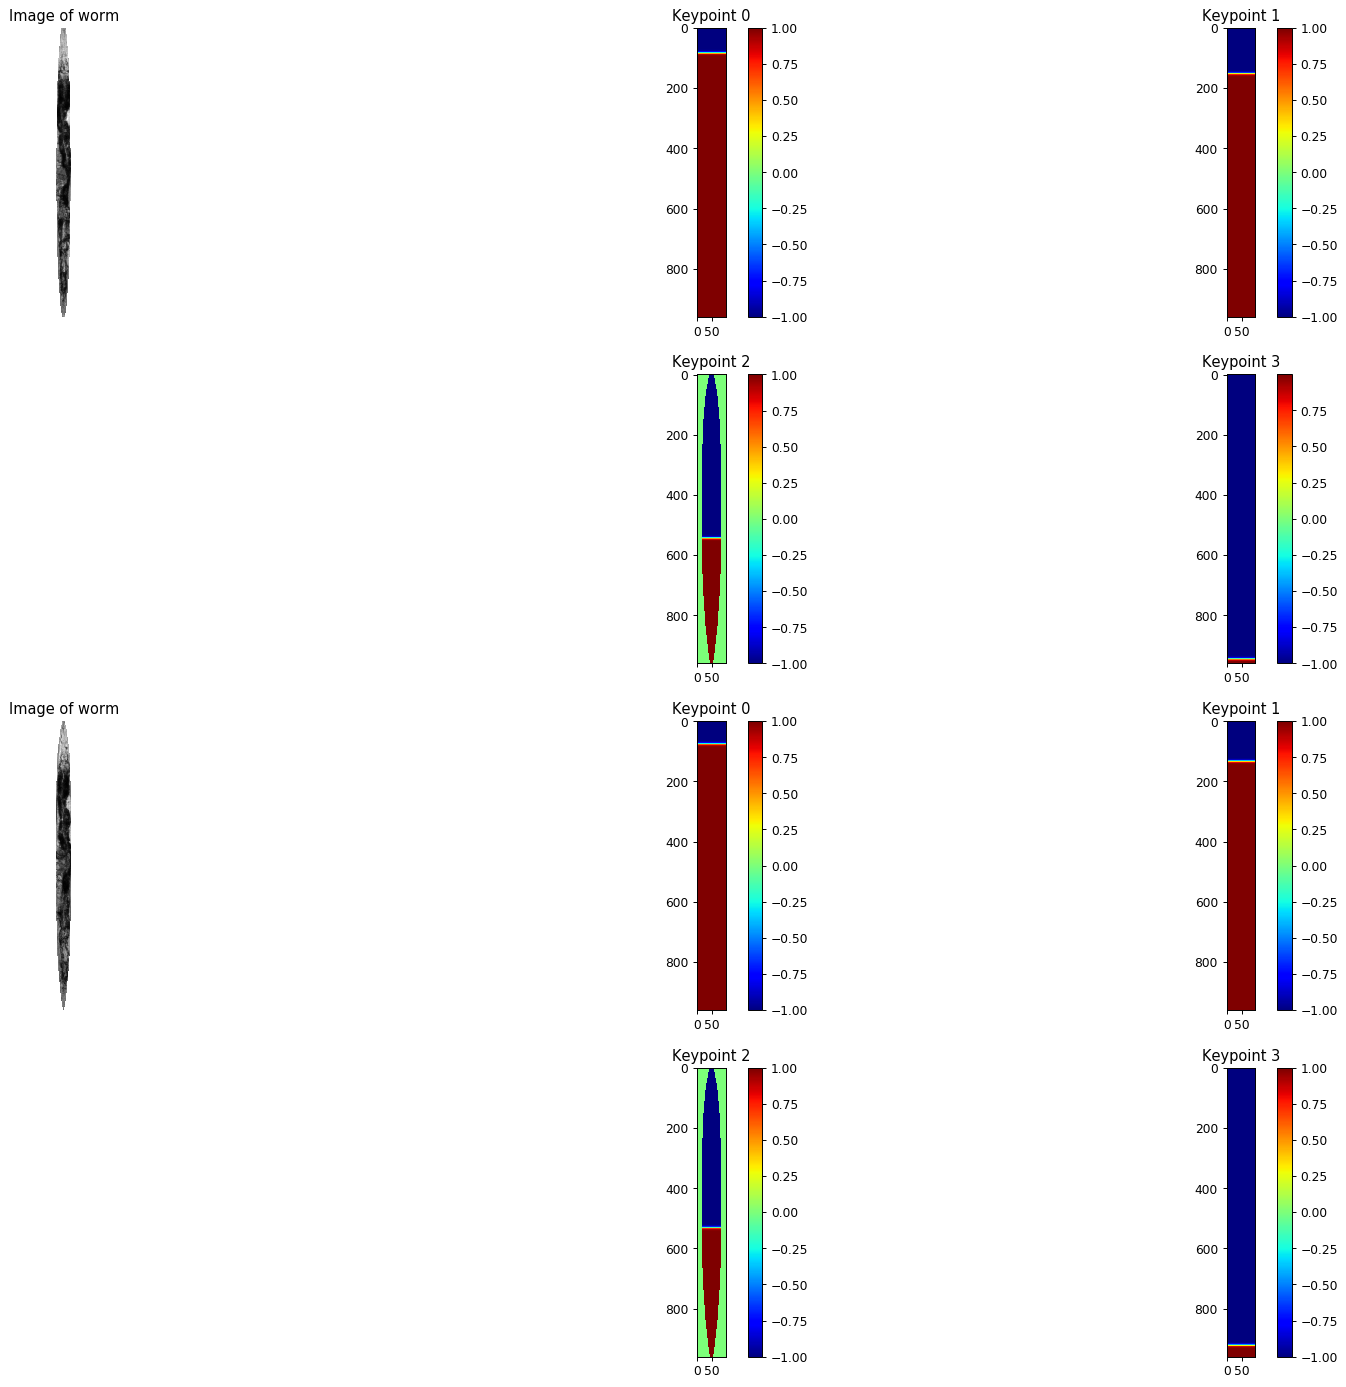

In [5]:
%matplotlib inline
#SCALE 0
sampler = iter(dataloaders['val'])
sample = sampler.next()
#imgList, keypoint0, keypoint1 =sample
imgList, keypoint_maps = sample
keypoint0, keypoint1, keypoint2, keypoint3 = keypoint_maps
print(imgList.shape)
print(keypoint0[0].shape)
print(len(keypoint0))

width_tck = keypoint_training.AVG_WIDTHS_TCK
worm_mask = worm_spline.worm_frame_mask(width_tck, image_size)
#scaled_mask = pyramid.pyr_down(worm_mask, downscale=2**3)
scaled_mask = worm_mask>0

figWinNumHeight, figWinNumWidth, subwinCount = 4, 3, 1
plt.figure(figsize=(22,20), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

for sampleIndex in range(2):
    # visualize image
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    image = imgList[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Image of worm')
    
    #keypoint0
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    kp_map = keypoint0[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(kp_map[0], cmap='jet')
    plt.axis('on')
    plt.colorbar()
    plt.title('Keypoint '+str(0))
    
    #keypoint1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    kp_map = keypoint1[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(kp_map[0], cmap='jet')
    plt.axis('on')
    plt.colorbar()
    plt.title('Keypoint '+str(1))
    
    subwinCount+=1
    
    #keypoint2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    kp_map = keypoint2[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    kp_map[0][~scaled_mask]=0
    plt.imshow(kp_map[0], cmap='jet')
    plt.axis('on')
    plt.colorbar()
    plt.title('Keypoint '+str(2))
    
    #keypoint3
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    kp_map = keypoint3[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(kp_map[0], cmap='jet')
    plt.axis('on')
    plt.colorbar()
    plt.title('Keypoint '+str(3))

In [5]:
sampler = iter(dataloaders['val'])
sample = sampler.next()
imgList, keypoint_maps = sample
keypoint0, keypoint1, keypoint2, keypoint3 = keypoint_maps
kp0 = keypoint0[0][0]
kp1 = keypoint1[0][0]
kp2 = keypoint2[0][0]
kp3 = keypoint3[0][0]

In [7]:
kp0 = kp0[0].cpu().detach().numpy()
kp1 = kp1[0].cpu().detach().numpy()
kp2 = kp2[0].cpu().detach().numpy()
kp3 = kp3[0].cpu().detach().numpy()

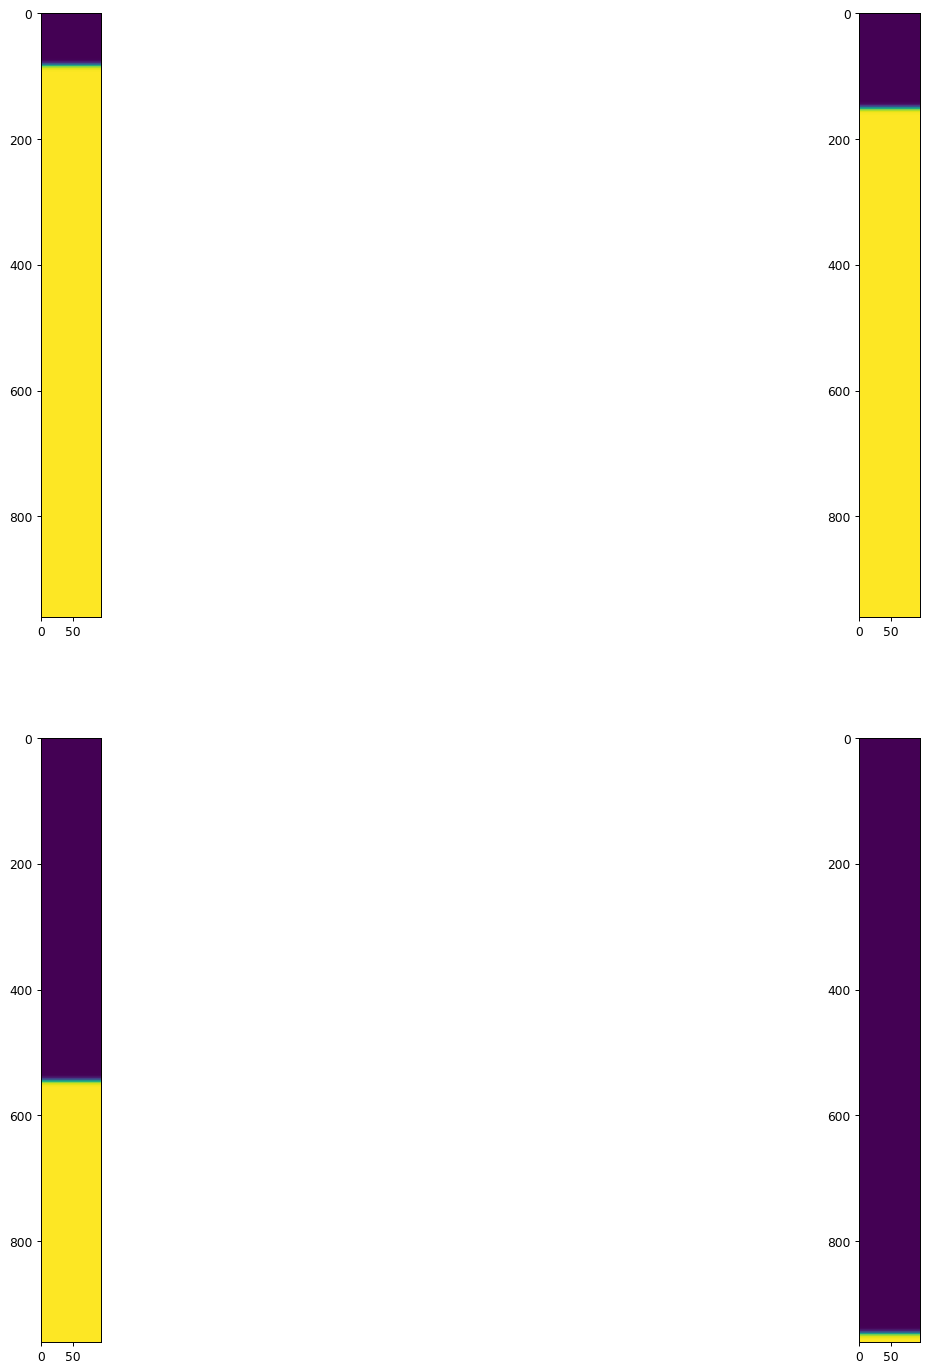

In [8]:
figWinNumHeight, figWinNumWidth, subwinCount = 2, 2, 1
plt.figure(figsize=(22,20), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(kp0)
plt.title('Keypoint '+str(0))

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(kp1)
plt.title('Keypoint '+str(1))

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(kp2)
plt.title('Keypoint '+str(2))

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(kp3)
plt.title('Keypoint '+str(3))

In [49]:
tp = val[0]
kp_map_generator = training_dataloaders.GaussianKpMap1D(covariate=200, max_val=1)
data_generator = training_dataloaders.WormKeypointDataset(kp_map_generator,downscale=downscale, scale=scale, image_size=image_size)

img, kp_maps = data_generator(tp)
keypoint0, keypoint1, keypoint2, keypoint3 = kp_maps

figWinNumHeight, figWinNumWidth, subwinCount = 2, 2, 1
plt.figure(figsize=(10,15), dpi=1000, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(keypoint0[0][0], cmap='viridis')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(keypoint1[0][0], cmap='viridis')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(keypoint2[0][0], cmap='viridis')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(keypoint3[0][0], cmap='viridis')
plt.colorbar()
plt.savefig('/Users/nlaird/Documents/Grad_School_Years/5th_year/Presentations/reproducibility/1DGaussian/kp_maps_200.png', dpi=1200)

In [10]:
kp0 = keypoint0[0][0]
kp1 = keypoint1[0][0]
kp2 = keypoint2[0][0]
kp3 = keypoint3[0][0]

In [11]:
def get_keypoint_coords(timepoint, image_shape):
    annotations = timepoint.annotations
    center_tck, width_tck = annotations['pose']
    keypoints = annotations['keypoints']

    #step 1: get the x,y positions in the new image shape
    length = spline_geometry.arc_length(center_tck)
    sample_dist = interpolate.spline_interpolate(width_tck, length).max()+20
    width = int(round(sample_dist*2))

    xs = numpy.array([keypoints[k][0] for k in ('anterior bulb', 'posterior bulb', 'vulva', 'tail')])
    x_percent = xs/length
    new_xs = x_percent*image_shape[0]

    #get y coordinates
    #put all keypoints except vulva at the midline
    ys = [int(image_shape[1]/2)]*len(new_xs)
    vulvax = int(new_xs[2])
    avg_widths = interpolate.spline_interpolate(keypoint_training.AVG_WIDTHS_TCK, image_shape[0])
    vulvay = avg_widths[vulvax]
    #widths are wrt the midline, so put vulva on correct side
    ys[2] = (image_shape[1]/2) - vulvay

    return new_xs, ys

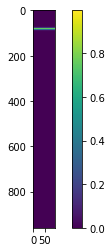

In [12]:
abs_map = 1 - abs(kp0)

plt.imshow(abs_map)
plt.colorbar()

In [14]:
tp.annotations['keypoints']

{'anterior bulb': (57.79690983125866, 2.9735103559070097),
 'posterior bulb': (105.77925006852999, 5.699779687570157),
 'vulva': (383.31346803183806, -19.927152030063404),
 'tail': (666.3002246584724, 0.24724102424386274),
 'gfp tail': (627.5, 1.0)}

In [15]:
pred_x, pred_y = production_utils.weighted_mean(abs_map)`

pred_x, pred_y:  82.00240442772011 47.50000110582653


In [16]:
production_utils.normalize_pred_keypoints(tp, tp.annotations['keypoints'], downscale=1, image_size=image_size)

{'anterior bulb': (82.00839456923379, 48),
 'posterior bulb': (150.09083534369205, 48),
 'vulva': (543.8858620959561, 16.888569946846992),
 'tail': (945.4175298453177, 48),
 'gfp tail': (890.3636499327622, 48)}

In [14]:
model_path_root = '/Volumes/lugia_array/Laird_Nicolette/deep_learning/keypoint_detection/new_api/production_dataloader_test/new_kp_maps/gaussian_kp/960x96_cov100_max1/'
model_paths={'ant_pharynx':model_path_root+"ant_pharynx/bestValModel.paramOnly", 
             'post_pharynx':model_path_root+'post_pharynx/bestValModel.paramOnly', 
             'vulva_class':model_path_root+'Vulva_Classifier/bestValModel.paramOnly',
             'vulva_kp':model_path_root+'vulva_kp/bestValModel.paramOnly', 
             'tail':model_path_root+'tail/bestValModel.paramOnly'}

In [22]:
tp = train[0]
img, kp_maps = data_generator(tp)
keypoints = tp.annotations['keypoints']
model_metrics_utils.predict_image(img, keypoints, downscale=downscale, model_paths=model_paths)

true vulva:  -19.02631895739252     vulva out:  tensor([[-1.4043,  1.2315]], grad_fn=<AddmmBackward>) 1
using pretrained model
pred_x, pred_y:  89.14431935547852 48.01209445654963
using pretrained model
pred_x, pred_y:  162.11274920216684 48.042932068354396
using pretrained model
pred_x, pred_y:  525.4161136028639 14.915479898269034
using pretrained model
pred_x, pred_y:  905.8338168084451 48.00246729706589


{'anterior bulb': (89.14431935547852, 48.01209445654963),
 'posterior bulb': (162.11274920216684, 48.042932068354396),
 'vulva': (525.4161136028639, 14.915479898269034),
 'tail': (905.8338168084451, 48.00246729706589)}

{'anterior bulb': (60.64956286513877, 2.974012670157819), 'posterior bulb': (111.19086525275442, 2.974012670157819), 'vulva': (362.7081700758299, -19.02631895739252), 'tail': (629.6851673939408, 0.0009948826510139952), 'gfp tail': (605.0, 0.5)}


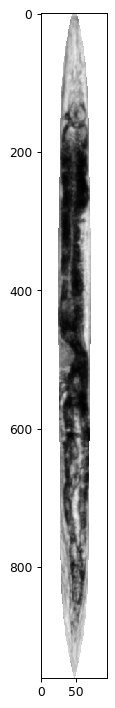

In [26]:
worm_frame_image = production_utils.get_worm_frame_image(tp, downscale, image_size, reflect=True)
print(tp.annotations['keypoints'])
plt.figure(figsize=(10,10), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.imshow(img[2], cmap='gray')

{'anterior bulb': (57.79690983125866, 2.9735103559070097), 'posterior bulb': (105.77925006852999, 5.699779687570157), 'vulva': (383.31346803183806, -19.927152030063404), 'tail': (666.3002246584724, 0.24724102424386274), 'gfp tail': (627.5, 1.0)}


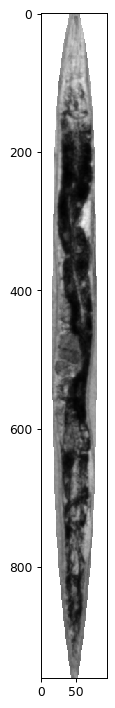

In [13]:
worm_frame_image = production_utils.get_worm_frame_image(tp, downscale, image_size, reflect=False)
print(tp.annotations['keypoints'])
plt.figure(figsize=(10,10), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.imshow(worm_frame_image, cmap='gray')

In [31]:
v_data_generator = worm_datasets.VulvaClassifier(downscale=downscale, image_size=image_size)
img, v = v_data_generator(tp)

In [27]:
regModel = keypoint_annotation_model.init_vuvla_class_model()
regModel.load_state_dict(torch.load(model_paths['vulva_class'], map_location='cpu'))
regModel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
tensor_img = torch.tensor(img).unsqueeze(0)
tensor_img.size()

torch.Size([1, 3, 960, 96])

In [30]:
regModel(tensor_img)

tensor([[-1.4043,  1.2315]], grad_fn=<AddmmBackward>)

In [29]:
worm_frame_image = production_utils.get_worm_frame_image(tp, downscale, image_size, reflect=True)
import freeimage
from zplib.image import colorize
colorize.write_scaled(worm_frame_image, ,)

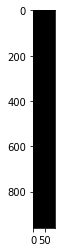

In [36]:
scaled = colorize.scale(worm_frame_image, 0, 255)


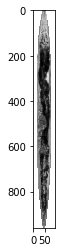

In [37]:
worm_frame_image = production_utils.get_worm_frame_image(val[0], downscale, image_size)
plt.imshow(worm_frame_image,cmap='gray')

In [46]:
scaled = colorize.scale(worm_frame_image, output_max=255)
freeimage.write(np.dstack((scaled, scaled, scaled)).astype(numpy.uint8), '/Users/nlaird/Documents/Grad_School_Years/5th_year/Presentations/reproducibility/sigmoid/worm_image.png')